In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd


from autograd import grad
from collections import Counter, defaultdict
from itertools import compress
from scipy.io import loadmat
from scipy.optimize import linear_sum_assignment
from scipy.sparse.linalg import svds
from scipy.special import huber
from sklearn.preprocessing import StandardScaler
from time import process_time

import warnings
warnings.simplefilter('ignore')

In [2]:
# 定义segment search函数，是用来在迭代方向已经确定的情况下求步长用的
def segment_search(f, grad_f, x, y, tol=1e-6, stepsize=True):
    #Minimizes f over [x, y], i.e., f(x+gamma*(y-x)) as a function of scalar gamma in [0,1]
    
    # restrict segment of search to [x, y]
    d = (y-x).copy()
    left, right = x.copy(), y.copy()
    
    # if the minimum is at an endpoint
    if np.dot(d, grad_f(x))*np.dot(d, grad_f(y)) >= 0:
        if f(y) <= f(x):
            return y, 1
        else:
            return x, 0
    
    # apply golden-section method to segment
    gold = (1+np.sqrt(5))/2
    improv = np.inf
    while improv > tol:
        old_left, old_right = left, right
        new = left+(right-left)/(1+gold)
        probe = new+(right-new)/2
        if f(probe) <= f(new):
            left, right = new, right
        else:
            left, right = left, probe
        improv = np.linalg.norm(f(right)-f(old_right))+np.linalg.norm(f(left)-f(old_left))
    x_min = (left+right)/2
    
    # compute step size gamma
    gamma = 0
    if stepsize == True:
        for i in range(len(d)):
            if d[i] != 0:
                gamma = (x_min[i]-x[i])/d[i]
                break
                
    return x_min, gamma

In [3]:
# frank wolfe 算法
def fw(f, grad_f, L, x, step='ls', f_tol=1e-6, time_tol=np.inf):
    # f_tol 为判断结果收敛的常数，time_tol 为最大时间
    
    values, times, oracles, gaps = [f(x)], [0], [0], []
    f_improv = np.inf
    
    while f_improv > f_tol and np.sum(times) < time_tol:
        f_old = f(x)
        start = process_time()
        grad_f_x = grad_f(x)        
        v = lmo(grad_f_x)
        # lmo = lambda g: V[np.argmin(g)] 即最优顶点        
        t1 = process_time()
        gaps.append(np.dot(grad_f_x, x-v))
        t2 = process_time()

        #if step == 't':
        #    gamma = 2/(len(values)+1)
        #    x = (1-gamma)*x+gamma*v
        #elif step == 'L':
        #    gamma = min(np.dot(grad_f_x, x-v)/(L*np.linalg.norm(x-v)**2), 1)
        #    x = (1-gamma)*x+gamma*v
        #以上都是一些可供选择的寻找步长的方法，这里不会用到
        if step == 'ls':
            x, gamma = segment_search(f, grad_f, x, v)
        else:
            d = v-x
            gamma = min(-np.dot(d, grad_f_x)/np.dot(d, (np.dot(step, d))), 1)
            x = x+gamma*d
            # d为x到最优顶点方向，gamma为行走步长所占比例
        
        end = process_time()
        values.append(f(x))
        times.append(end-start+t1-t2)
        oracles.append(1)
        f_improv = f_old-f(x)
        
    return x, values, times, oracles, gaps


# away-step frank-wolfe 算法
def afw(f, grad_f, L, x, step='ls', f_tol=1e-6, time_tol=np.inf):
    
    values, times, oracles, gaps = [f(x)], [0], [0], []
    f_improv = np.inf
    S, alpha = [x.copy()], [1]
    
    while f_improv > f_tol and np.sum(times) < time_tol:        
        f_old = f(x)        
        start = process_time()
        grad_f_x = grad_f(x)
        v = lmo(grad_f_x)       
        t1 = process_time()
        gaps.append(np.dot(grad_f_x, x-v))
        t2 = process_time()       
        i_max = np.argmax(np.dot(S, grad_f_x))
        a = S[i_max]
        
        if np.dot(grad_f_x, v-x) <= np.dot(grad_f_x, x-a):
            #if step == 'L':
            #    gamma = min(np.dot(grad_f_x, x-v)/(L*np.linalg.norm(x-v)**2), 1)
            #    x = (1-gamma)*x+gamma*v
            #以上都是一些可供选择的寻找步长的方法，这里不会用到
            if step == 'ls':
                x, gamma = segment_search(f, grad_f, x, v)
            else:
                d = v-x
                gamma = min(-np.dot(d, grad_f_x)/np.dot(d, (np.dot(step, d))), 1)
                x = x+gamma*d
                # d为x到最优顶点方向，gamma为行走步长所占比例
            S.append(v)
            alpha = list((1-gamma)*np.array(alpha))+[gamma]
        # 以上是正常的frank-wolfe
        
        else:
            gamma_max = alpha[i_max]/(1-min(alpha[i_max], 0.99999))
            #if step == 'L':
            #    gamma = min(np.dot(grad_f_x, a-x)/(L*np.linalg.norm(a-x)**2), gamma_max)
            #    x = (1+gamma)*x-gamma*a
            #    alpha = list((1+gamma)*np.array(alpha))
            #    alpha[i_max] -= gamma
            #    if gamma == gamma_max:
            #        del alpha[i_max]
            #        del S[i_max]
            #以上都是一些可供选择的寻找步长的方法，这里不会用到
            if step == 'ls':
                x, gamma = segment_search(f, grad_f, x, (1+gamma_max)*x-gamma_max*a)
                alpha = list((1+gamma*gamma_max)*np.array(alpha))
                alpha[i_max] -= gamma*gamma_max
                if gamma == 1:
                    del alpha[i_max]
                    del S[i_max]
            else:
                d = x-a
                gamma = min(-np.dot(d, grad_f_x)/np.dot(d, (np.dot(step, d))), gamma_max)
                x = x+gamma*d
                alpha = list((1+gamma)*np.array(alpha))
                alpha[i_max] -= gamma
                if gamma == gamma_max:
                    del alpha[i_max]
                    del S[i_max]
            # 当不满足判定条件时，允许方向离开顶点，成为 Away-step的frank-wolfe
                    
        end = process_time()
        values.append(f(x))
        times.append(end-start+t1-t2)
        oracles.append(2)
        f_improv = f_old-f(x)

    return x, values, times, oracles, gaps

In [4]:
# 定义align函数，判定d和hat_d的夹角大小，即余弦值
def align(d, hat_d):    
    if np.linalg.norm(hat_d) < 1e-15:
        return -1    
    else:
        return np.dot(d, hat_d)/(np.linalg.norm(d)*np.linalg.norm(hat_d))

    
# 定义 Non-Negative Matching Pursuit 算法函数，即解决在锥里的二次优化子问题，即通过多个顶点方向的线性组合确定下降方向
def nnmp(x, grad_f_x, align_tol, K, traffic):
    # Minimizes ||-grad_f_x-d||_2^2/2 s.t. d in cone(V-x)
    
    d, Lbd, flag = np.zeros(len(x)), 0, True 
    G = grad_f_x+d
    # G为当前下降方向与负梯度的差值，即论文中的r
    align_d = align(-grad_f_x, d)
    # 将初始值d_0设为0
    
    for k in range(K):
    # K为最多寻找的顶点个数 
    
        if traffic == True:
            G = np.maximum(G, 0)
        # 针对traffic实验，需要保证G的每一个分量都不为负
        
        u = lmo(G)-x
        # 寻找与残差方向最接近的顶点方向
        d_norm = np.linalg.norm(d)
        if d_norm > 0 and np.dot(G, -d/d_norm) < np.dot(G, u):
            u = -d/d_norm
            flag = False
        lbd = -np.dot(G, u)/np.linalg.norm(u)**2
        dd = d+lbd*u
        align_dd = align(-grad_f_x, dd)
        align_improv = align_dd-align_d
        # 计算该顶点方向的权重系数，进行线性组合
        
        # 判定d更新后的角度优化值有没有大于阈值align_tol，即论文中的delta，是人为定义的一个较小数
        if align_improv > align_tol:
            d = dd
            Lbd = Lbd+lbd if flag == True else Lbd*(1-lbd/d_norm)
            G = grad_f_x+d
            align_d = align_dd
            flag = True
        # 如果是则说明这步d的更新比较有价值，确认更新并继续迭代
        else:
            break
        # 如果否则说明进一步寻找更多顶点去优化下降方向没有太大意义，停止迭代      
    return d/Lbd, k, align_d

# boost frank-wolfe算法
def boostfw(f, grad_f, L, x, step='ls', f_tol=1e-6, time_tol=np.inf, align_tol=1e-3, K=500, traffic=False): 
    if traffic == False:
        values, times, oracles, gaps = [f(x)], [0], [0], [np.dot(grad_f(x), x-lmo(grad_f(x)))]
        f_improv = np.inf
        start = process_time()
        x = lmo(grad_f(x))
        end = process_time()
        values.append(f(x))
        times.append(end-start)
        oracles.append(1)
    else:
        values, times, oracles, gaps = [f(x)], [0], [0], []
        f_improv = np.inf
    
    while f_improv > f_tol and np.sum(times) < time_tol:      
        f_old = f(x)
        start = process_time()        
        grad_f_x = grad_f(x)     
        t1 = process_time()
        gaps.append(np.dot(grad_f_x, x-lmo(grad_f_x)))
        t2 = process_time()       
        g, num_oracles, align_g = nnmp(x, grad_f_x, align_tol, K, traffic)
        # 计算得到组合方向
        
        #if step == 'L':
        #    gamma = min(align_g*np.linalg.norm(grad_f_x)/(L*np.linalg.norm(g)), 1)
        #    x = x+gamma*g
        #以上都是一些可供选择的寻找步长的方法，这里不会用到
        if step == 'ls':
            x, gamma = segment_search(f, grad_f, x, x+g)
        else:
            gamma = min(-np.dot(g, grad_f_x)/np.dot(g, (np.dot(step, g))), 1)
            x = x+gamma*g
            # g为x到最优顶点的线性组合的方向，gamma为行走步长所占比例
        
        end = process_time()
        values.append(f(x))
        times.append(end-start+t1-t2)
        oracles.append(num_oracles)
        f_improv = f_old-f(x)
        
    return x, values, times, oracles, gaps

In [5]:
# 画图设置

styles = {'afwls':'-', 'afwL':'--', 'fw':'-', 'dicg':'-',
          'boostfwL':'--', 'boostfwls':'-', 'boostdicg':'-'}
colors = {'afwls':'tab:blue', 'afwL':'tab:blue', 'fw':'tab:red', 'dicg':'tab:green',
          'boostfwL':'tab:orange', 'boostfwls':'tab:orange', 'boostdicg':'tab:purple'}
labels = {'afwls':'AFW-ls', 'afwL':'AFW-L', 'fw':'FW-ls', 'dicg':'DICG',
          'boostfwL':'BoostFW-L', 'boostfwls':'BoostFW-ls', 'boostdicg':'BoostDICG'}

In [6]:
# 以下都是画图相关设置

def plotter_oracles(res, styles, colors, labels, outfilename=None):
    
    res_oracles = defaultdict(list)
    for alg in res.keys():
        for i in range(1, len(res[alg][1])):
            for j in range(res[alg][3][i]):
                res_oracles[alg].append(res[alg][1][i-1])
    
    fig = plt.figure()
    fig.set_figheight(3)
    fig.set_figwidth(10)

    plt.subplot(1, 3, 1)
    for alg in res.keys():
        plt.plot(np.arange(len(res[alg][1])), res[alg][1], linestyle=styles[alg], color=colors[alg],
                 label=labels[alg])
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Function value')
    plt.xlabel('Iteration')
    plt.tick_params(which='minor', left=False)
    plt.grid(linestyle=':')

    plt.subplot(1, 3, 2)
    for alg in res.keys():
        plt.plot(np.arange(np.sum(res[alg][3])), res_oracles[alg], linestyle=styles[alg], color=colors[alg])
    plt.yscale('log')
    plt.xlabel('Oracle calls')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(linestyle=':')

    plt.subplot(1, 3, 3)
    for alg in res.keys():
        plt.plot(np.cumsum(res[alg][2]), res[alg][1], linestyle=styles[alg], color=colors[alg])
    plt.yscale('log')
    plt.xlabel('CPU time (s)')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(linestyle=':')

    if outfilename is not None:
        plt.savefig(outfilename, dpi=200, bbox_inches='tight')
        
    plt.show()

def plotter_gaps(res, styles, colors, labels, outfilename=None):
    
    res_oracles = defaultdict(list)
    for alg in res.keys():
        for i in range(len(res[alg][4])):
            for j in range(res[alg][3][i+1]):
                res_oracles[alg].append(res[alg][4][i])
    
    fig = plt.figure()
    fig.set_figheight(3)
    fig.set_figwidth(10)

    plt.subplot(1, 3, 1)
    for alg in res.keys():
        plt.plot(np.arange(len(res[alg][4])), res[alg][4], linestyle=styles[alg], color=colors[alg],
                 label=labels[alg])
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Duality gap')
    plt.xlabel('Iteration')
    plt.tick_params(which='minor', left=False)
    plt.grid(linestyle=':')

    plt.subplot(1, 3, 2)
    for alg in res.keys():
        plt.plot(np.arange(np.sum(res[alg][3])), res_oracles[alg], linestyle=styles[alg], color=colors[alg])
    plt.yscale('log')
    plt.xlabel('Oracle calls')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(linestyle=':')

    plt.subplot(1, 3, 3)
    for alg in res.keys():
        plt.plot(np.cumsum(res[alg][2][1:]), res[alg][4], linestyle=styles[alg], color=colors[alg])
    plt.yscale('log')
    plt.xlabel('CPU time (s)')
    plt.tick_params(which='both', left=False, labelleft=False)
    plt.grid(linestyle=':')

    if outfilename is not None:
        plt.savefig(outfilename, dpi=200, bbox_inches='tight')
        
    plt.show()

AFW-ls
BoostFW
FW-ls


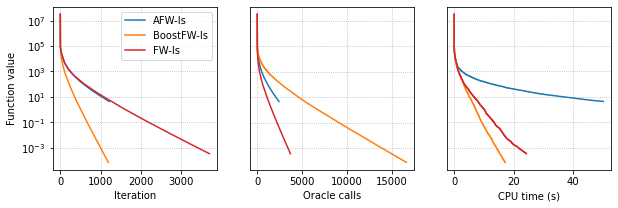

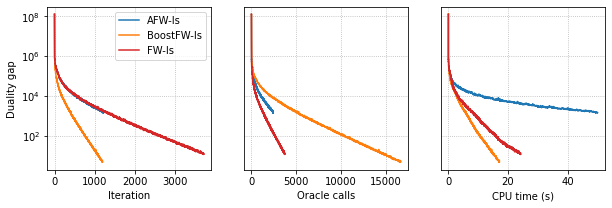

In [7]:
# 这才是创建输入数据集！第一个实验，是最基本的白噪声问题，目标函数随机，可行域为 |x|一范数 <= |x_star|一范数
# sparse signal recovery

m, n, sigma = 200, 500, 0.05

x_star = np.random.randn(n)
A = np.random.randn(m, n)
y = np.dot(A, x_star)+sigma*np.random.randn(m)
#随机生成x_star，A，并加以随机噪声得到y
f = lambda z: np.linalg.norm(y-np.dot(A, z[:n]-z[n:]), 2)**2
grad_f = grad(f)
L = 0 # not used
# 目标函数f为 |y-Ax| 二范数的平方
tau = np.linalg.norm(x_star, 1)
V = tau*np.identity(2*n)
x = V[np.random.randint(len(V))].copy()
# 随机生成一个其中一个分量等于x_star的一范数，其余分量都为0，维度为两倍x_star的向量，即为x
# 在定义域，|x|一范数 <= |x_star|一范数 ，x即为此多面体可行域的一个顶点，作为迭代初始值
lmo = lambda g: V[np.argmin(g)]
# 定义求最优顶点的函数，算法里面会用到

# Q是用来求步长的，在这个实验中不需要用到segment search函数求步长
Q = np.matmul(np.transpose(A), A)
Q = 2*np.concatenate((np.concatenate((Q, -Q), axis=1), np.concatenate((-Q, Q), axis=1)), axis=0)

f_tol, time_tol, align_tol = 1e-6, 50, 1e-3

res = {}

print('AFW-ls')
res['afwls'] = afw(f, grad_f, L, x, step=Q, f_tol=f_tol, time_tol=time_tol)
print('BoostFW')
res['boostfwls'] = boostfw(f, grad_f, L, x, step=Q, f_tol=f_tol, time_tol=time_tol, align_tol=align_tol)
print('FW-ls')
res['fw'] = fw(f, grad_f, L, x, step=Q,  f_tol=f_tol, time_tol=time_tol)
plotter_oracles(res, styles, colors, labels)
plotter_gaps(res, styles, colors, labels)

In [8]:
# 这是第二个实验，为一个逻辑回归算法，数据集来自两个csv文件
# Sparse logistic regression on the Gisette dataset
A = pd.read_csv('gisette_data.csv', header=None)
y = pd.read_csv('gisette_labels.csv', header=None)[0].values

scaler = StandardScaler()
A = scaler.fit_transform(A)
m, n = A.shape
f = lambda z: np.sum(np.log(1+np.exp(-y*np.dot(A, z[:n]-z[n:]))))/m
grad_f = grad(f)
L = 0.5
tau = 10
V = tau*np.identity(2*n)
x = V[np.random.randint(len(V))].copy()

lmo = lambda g: V[np.argmin(g)]
f_tol, time_tol, align_tol = 1e-6, 80, 1e-4
res = {}

print('AFW-ls')
res['afwls'] = afw(f, grad_f, L, x, step='ls', f_tol=f_tol, time_tol=time_tol)
print('BoostFW-ls')
res['boostfwls'] = boostfw(f, grad_f, L, x, step='ls', f_tol=f_tol, time_tol=time_tol, align_tol=align_tol)
print('FW-ls')
res['fw'] = fw(f, grad_f, L, x, step='ls',  f_tol=f_tol, time_tol=time_tol)
plotter_oracles(res, styles, colors, labels)
plotter_gaps(res, styles, colors, labels)

FileNotFoundError: [Errno 2] File gisette_data.csv does not exist: 'gisette_data.csv'

In [ ]:
# 这是第三个实验，是一个利用dijstra求解的交通分配问题，数据集为随机生成，具体问题见paper的式(6)
# Traffic assignment problem

m, n, p = 25, 20, 0.5
mn = m*n

vertices = np.arange(mn)

DG = nx.DiGraph()

for i in vertices[:-m]:
    l = i//m
    for h in range(m):
        if np.random.binomial(1, p) == 1:
            DG.add_edge(i, (l+1)*m+h)

out_neighbors = defaultdict(list)
for i, j in DG.edges:
    out_neighbors[i].append(j)

OD = []
for s in vertices:
    OD.extend([(s, j) for j in out_neighbors[s]])
    queue = out_neighbors[s].copy()
    dequeued = []
    while len(queue) > 0:
        i = queue[0]
        dequeued.append(i)
        queue = queue[1:]
        for j in out_neighbors[i]:
            if j not in dequeued and j not in queue:
                OD.append((s, j))
                queue.append(j)

demands = {}
for i, j in OD:
    demands[i, j] = np.random.random()

def lmo(g):
    
    v = np.zeros((mn, mn))
    
    weights = np.reshape(g, (mn, mn))
    for i in out_neighbors.keys():
        for j in out_neighbors[i]:
            DG[i][j]['weight'] = weights[i][j]
    
    paths = dict(nx.all_pairs_dijkstra_path(DG))
    
    for s, t in OD:
        path = paths[s][t]
        for idx in range(len(path)-1):
            v[path[idx], path[idx+1]] += demands[s, t]
    
    return np.reshape(v, mn**2)

c = len(OD)/(m*n)

def f(x):
    X = np.reshape(x, (mn, mn))
    return sum([X[i, j]+0.03*X[i, j]**5/c**4 for i, j in DG.edges])/(mn**2)

grad_f = grad(f)

L = 0 # not used
x = lmo(np.random.random(mn**2))
f_tol, time_tol, align_tol = 1e-6, 120, 1e-3

res = {}

print('AFW-ls')
res['afwls'] = afw(f, grad_f, L, x, step='ls', f_tol=f_tol, time_tol=time_tol)
print('BoostFW-ls')
res['boostfwls'] = boostfw(f, grad_f, L, x, step='ls', f_tol=f_tol, time_tol=time_tol, align_tol=align_tol, K=5, traffic=True)
print('FW-ls')
res['fw'] = fw(f, grad_f, L, x, step='ls',  f_tol=f_tol, time_tol=time_tol)
plotter_oracles(res, styles, colors, labels)
plotter_gaps(res, styles, colors, labels)